In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [2]:
nels = pd.read_csv('data/NELS_Filtered.csv')
nels_columns = pd.read_csv('data/NELS_Subset_Columns.csv')
nels_columns_readable = pd.read_csv('data/NELS_Subset_Columns_Human_Readable.csv')
nels_subset = nels[list(nels_columns.columns)]
nels_subset.columns = list(nels_columns_readable.columns)

In [3]:
nels_subset.columns[:100]

Index(['StudentId', 'Degree', 'InSchool12thGrade', 'Sex',
       'MaleGuardianOccupation', 'FemaleGuardianOccupation', 'Race',
       'ParentsHighestLevelEducation', 'HasMoreThan50Books',
       'HasSpecificPlaceForStudy', 'ReceivesNewspaper', 'FamilyHasComputer',
       'ParentsAttendedSchoolMeeting', 'ParentsSpokeWithCounselor',
       'ParentsCheckHomework', 'NoOneHomeWhenReturnFromSchool',
       'FathersWishes', 'MothersWishes', 'HoursWorkingForPayPerWeek',
       'SchoolWorkProblemsEighthGrade', 'TeachingIsGood',
       'TeachersInterestedInStudents', 'StudentDisruptions',
       'AcceleratedEnglish', 'AcceleratedHistory', 'AcceleratedScience',
       'AcceleratedMath', 'TimeSpentMath', 'TimeSpentScience',
       'TimeSpentEnglish', 'TimeSpentHistory', 'GradesMiddleSchoolEnglish',
       'GradesMiddleSchoolMath', 'GradesMiddleSchoolScience',
       'GradesMiddleSchoolHistory', 'PercentMinorityOfSchoolMiddleSchool',
       'PercentFreeLunchOfSchoolMiddleSchool',
       'Socio-econ

In [4]:
# Add 1st/2nd gen immigrant status 
# Native/non native english speaker

target_col = "GradesUndergrad" # Grades
nels_valid_grades = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Make binary decision >= 2.75 GPA
nels_valid_grades[target_col] = np.where(nels_valid_grades[target_col] <= 3, 1, 0)

# Shuffle randomly before training models
nels_valid_grades = nels_valid_grades.sample(frac=1).reset_index(drop=True)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["Degree", 
"StudentId", 
"HighestPostSecondaryEducationAttained", 
"AttendedFirstChoicePostSecondaryEducation",
"JobSatisfaction", 
"Income",
"TotalEarningsJob1",
"TotalEarningsJob2",
"CoursesAt2To4YearCollege"]

nels_valid_grades = nels_valid_grades[nels_valid_grades.columns.difference(columns_to_withhold)]

X = nels_valid_grades[nels_valid_grades.columns.difference([target_col])]
y = nels_valid_grades[target_col]


/home/mnpham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
# Run this cell to downsample
from sklearn.utils import resample
def resample_up_down(dataframe, upsample=True, target_col=target_col):
    # Separate majority and minority classes
    df_majority = dataframe[dataframe[target_col]==1]
    df_minority = dataframe[dataframe[target_col]==0]
    
    if upsample:
        # Upsample minority class
        df_minority_upsampled = resample(df_minority, 
                                        replace=True,
                                        n_samples=len(df_majority),
                                        random_state=0)
    
        # Combine majority class with upsampled minority class
        df_resampled = pd.concat([df_majority, df_minority_upsampled])
    else:
        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,
                                        n_samples=len(df_minority),
                                        random_state=0) 
        
        # Combine minority class with downsampled majority class
        df_resampled = pd.concat([df_majority_downsampled, df_minority])
        
    # Display new class counts
    print(df_resampled[target_col].value_counts())

    return df_resampled

nels_valid_grades = resample_up_down(nels_valid_grades, upsample=True, target_col=target_col)
X = nels_valid_grades.loc[:, nels_valid_grades.columns != target_col]
y = nels_valid_grades[target_col]           

1    6640
0    6640
Name: GradesUndergrad, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [7]:
rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)


RandomForestClassifier()

In [8]:
predictions = rf.predict(x_test)

In [9]:
print(classification_report(y_test, predictions)) # target_names=target_names

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2039
           1       0.94      0.94      0.94      1945

    accuracy                           0.94      3984
   macro avg       0.94      0.94      0.94      3984
weighted avg       0.94      0.94      0.94      3984



In [10]:
rf_cross = RandomForestClassifier()
scores = cross_val_score(rf, X, y, cv=5)
scores

array([0.95444277, 0.9563253 , 0.95707831, 0.95368976, 0.95368976])

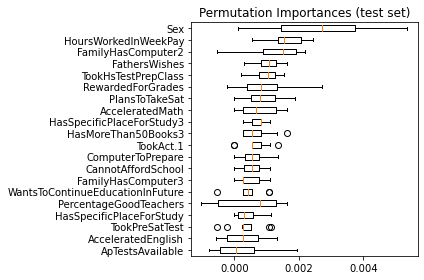

In [11]:
result = permutation_importance(
    rf, x_test, y_test, n_repeats=10, random_state=0, n_jobs=5, max_samples=1.0, scoring='f1'
)
sorted_idx = result.importances_mean.argsort()[-20:]

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


In [12]:
def return_real_column_name(human, human_list, yucky_list):
    return yucky_list[human_list.index(human)]

human_list = nels_columns_readable.columns.tolist()
yucky_list = nels_columns.columns.tolist()
return_real_column_name('Race', human_list, yucky_list)

'F4RACEM'

In [13]:
toy_columns = ['StudentId',
# .66 Acc RF
'Sex',
'Race',
'CompositeGrades',
'StandardizedTestQuartile',
'CategoricalGrades',

# .86 Acc RF (with base), .96 (second two), .58 (alone)
'TimeSpentOnHomeworkInSchool',
'TimeSpentOnHomeworkOutOfSchool',
'TimeSpentOnExtracurriculars',
'HelpWithEssays',
'ParentsCheckHomework',

# .92 Acc FR (with base), .82 (alone)
'HighSchoolHelpedWithSchoolApplication',
'HelpedWithFinancialAidApp',
'ParentsHighestLevelEducation',
'Socio-economicStatusQuartile',
'PrivateSchoolExpenses',
'PrivateTutoringExpenses',
'Tutored',
'FathersWishes',
'MothersWishes',

'GradesUndergrad']

In [14]:
# Only valid grades
toy_dataframe = nels_subset[(1 <= nels_subset[target_col]) & (nels_subset[target_col] <= 7)]

# Only white/black nonhispanic
toy_dataframe = toy_dataframe[(3 <= toy_dataframe['Race']) & (toy_dataframe['Race'] <= 4)]

# Shuffle randomly before training models
toy_dataframe = toy_dataframe.sample(frac=1).reset_index(drop=True)

toy_dataframe = toy_dataframe[toy_columns]

# Make binary decision >= 2.75 GPA
toy_dataframe[target_col] = np.where(toy_dataframe[target_col] <= 3, 1, 0)
make_string = False

if make_string:
    # Make binary decision >= 2.75 GPA
    toy_dataframe["Race"] = np.where(toy_dataframe["Race"] == 3, "Black", "White")
    toy_dataframe["Sex"] = np.where(toy_dataframe["Sex"] == 1, "Male", "Female")

toy_dataframe = resample_up_down(toy_dataframe, upsample=True, target_col=target_col)

# Withhold columns that are improper for prediction (like having completed PSE)
columns_to_withhold = ["StudentId"]

X = toy_dataframe[toy_dataframe.columns.difference([target_col]+columns_to_withhold)]
y = toy_dataframe[target_col]

1    5154
0    5154
Name: GradesUndergrad, dtype: int64


In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf = RandomForestClassifier() # max_iter=1000 
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

print(classification_report(y_test, predictions)) # target_names=target_names

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1048
           1       0.97      0.88      0.92      1014

    accuracy                           0.92      2062
   macro avg       0.93      0.92      0.92      2062
weighted avg       0.93      0.92      0.92      2062



In [16]:
tiny_test = toy_dataframe[:500]
student = int(tiny_test.iloc[0]['StudentId'])

/home/mnpham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<Figure size 720x576 with 0 Axes>

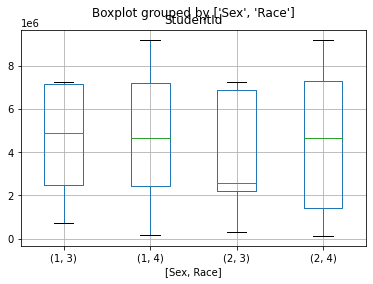

<Figure size 720x576 with 0 Axes>

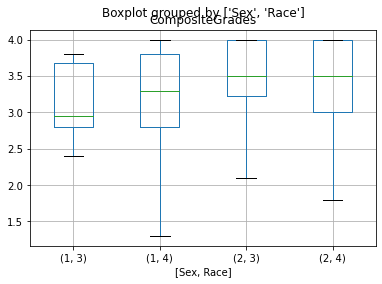

<Figure size 720x576 with 0 Axes>

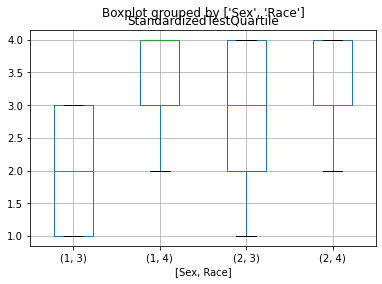

<Figure size 720x576 with 0 Axes>

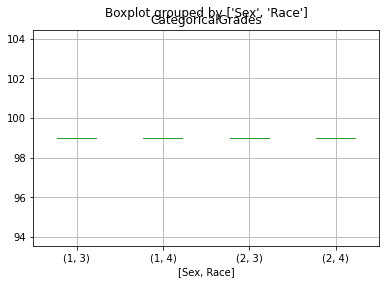

<Figure size 720x576 with 0 Axes>

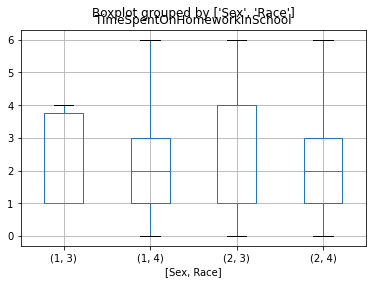

<Figure size 720x576 with 0 Axes>

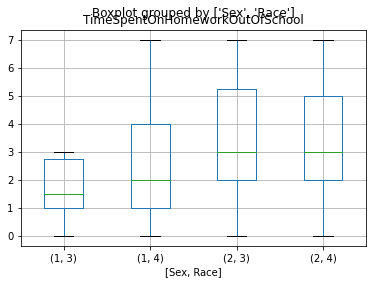

<Figure size 720x576 with 0 Axes>

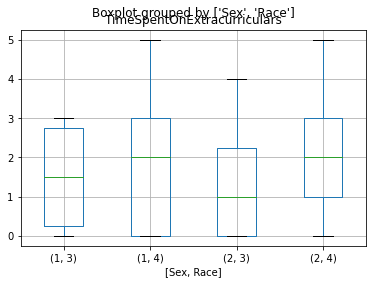

<Figure size 720x576 with 0 Axes>

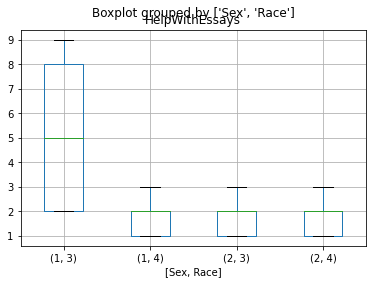

<Figure size 720x576 with 0 Axes>

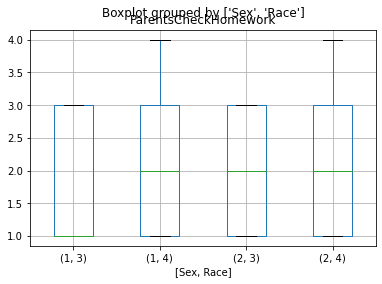

<Figure size 720x576 with 0 Axes>

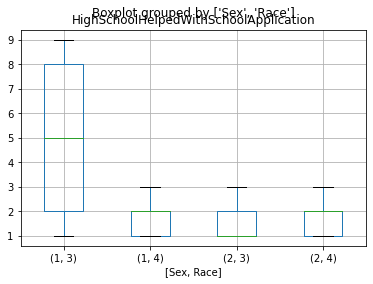

<Figure size 720x576 with 0 Axes>

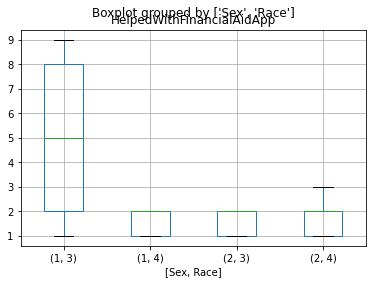

<Figure size 720x576 with 0 Axes>

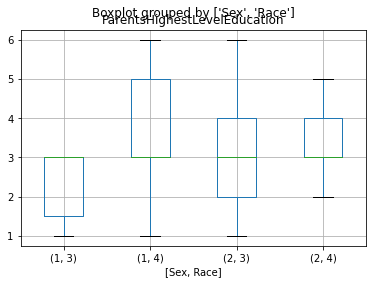

<Figure size 720x576 with 0 Axes>

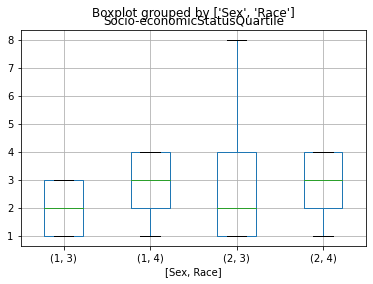

<Figure size 720x576 with 0 Axes>

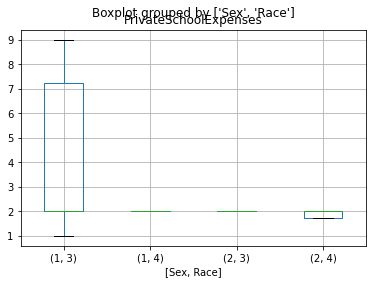

<Figure size 720x576 with 0 Axes>

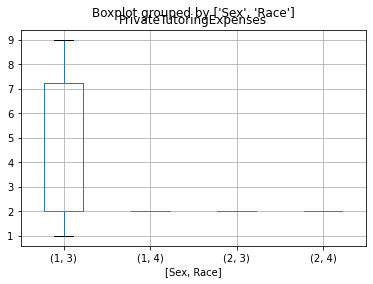

<Figure size 720x576 with 0 Axes>

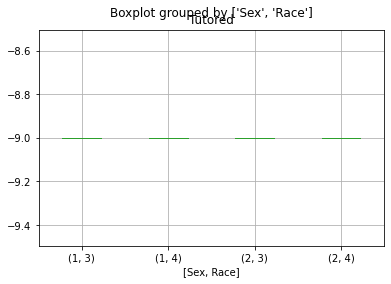

<Figure size 720x576 with 0 Axes>

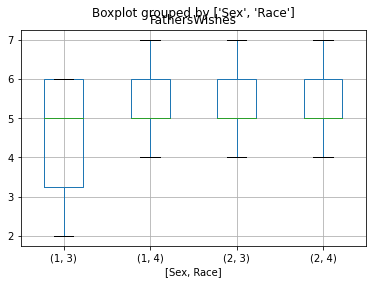

<Figure size 720x576 with 0 Axes>

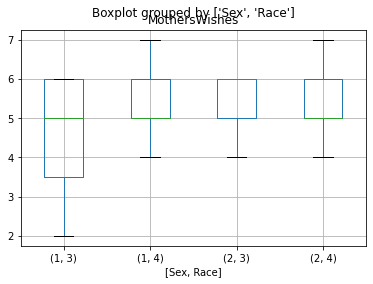

<Figure size 720x576 with 0 Axes>

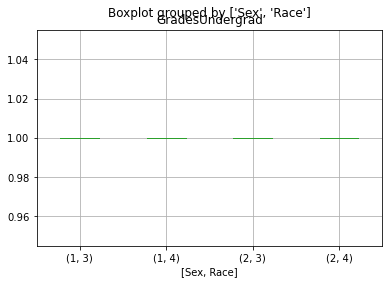

In [17]:
import matplotlib.pyplot as plt

for column in tiny_test:
    if column != 'Sex' and column != 'Race':
        plt.figure(figsize = [10, 8])
        tiny_test.boxplot([column], by=['Sex', 'Race'], showfliers=False)

In [18]:
from swap_auditor import NaiveSwapAuditor

new = NaiveSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
new.calculate_all_stability(marginal_features=['Tutored','Socio-economicStatusQuartile','FathersWishes'])

In [19]:
ind = student
s, marg = new._retrieve_stability_individual(ind)
print("\nFor individual: " + str(ind))
print('Stability: ' + str(s))
print(marg)


For individual: 744175
Stability: 1.0
Marginals:

Tutored: 1.0
Socio-economicStatusQuartile: 1.0
FathersWishes: 1.0
TutoredSocio-economicStatusQuartile: 1.0
TutoredFathersWishes: 1.0
Socio-economicStatusQuartileFathersWishes: 1.0
TutoredSocio-economicStatusQuartileFathersWishes: 1.0



In [20]:
new._calculate_subgroup_stability()
print(new.subgroup_stability)
sg = '14'
s, marg = new._retrieve_stability_subgroup(sg)
print("\nFor subgroup: " + str(sg))
print('Stability: ' + str(s))
print(marg)

{'14': (415373, 423948, {'Tutored': (60361, 60564), 'Socio-economicStatusQuartile': (59792, 60564), 'FathersWishes': (59314, 60564), 'TutoredSocio-economicStatusQuartile': (59581, 60564), 'TutoredFathersWishes': (59212, 60564), 'Socio-economicStatusQuartileFathersWishes': (58601, 60564), 'TutoredSocio-economicStatusQuartileFathersWishes': (58512, 60564)}), '13': (33687, 34300, {'Tutored': (4900, 4900), 'Socio-economicStatusQuartile': (4704, 4900), 'FathersWishes': (4900, 4900), 'TutoredSocio-economicStatusQuartile': (4704, 4900), 'TutoredFathersWishes': (4900, 4900), 'Socio-economicStatusQuartileFathersWishes': (4790, 4900), 'TutoredSocio-economicStatusQuartileFathersWishes': (4789, 4900)}), '24': (434565, 436800, {'Tutored': (62378, 62400), 'Socio-economicStatusQuartile': (61974, 62400), 'FathersWishes': (62278, 62400), 'TutoredSocio-economicStatusQuartile': (61966, 62400), 'TutoredFathersWishes': (62277, 62400), 'Socio-economicStatusQuartileFathersWishes': (61827, 62400), 'TutoredSoc

In [21]:
from swap_auditor import RandomizedSamplingSwapAuditor
randomized = RandomizedSamplingSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
randomized.calculate_all_stability(marginal_features=['Tutored','Socio-economicStatusQuartile','FathersWishes'], delta=0.1, epsilon=0.5)
# print(randomized.individual_stability)

Iterations: 19


In [22]:
ind = student
s, marg = randomized._retrieve_stability_individual(ind)
print("\nFor individual: " + str(ind))
print('Stability: ' + str(s))
print(marg)


For individual: 744175
Stability: 1.0
Marginals:

Tutored: 1.0
Socio-economicStatusQuartile: 1.0
FathersWishes: 1.0
TutoredSocio-economicStatusQuartile: 1.0
TutoredFathersWishes: 1.0
Socio-economicStatusQuartileFathersWishes: 1.0
TutoredSocio-economicStatusQuartileFathersWishes: 1.0



In [23]:
randomized._calculate_subgroup_stability()
print(randomized.subgroup_stability)
sg = '14'
s, marg = randomized._retrieve_stability_subgroup(sg)
print("\nFor subgroup: " + str(sg))
print('Stability: ' + str(s))
print(marg)

{'14': (26845, 27398, {'Tutored': (3895, 3914), 'Socio-economicStatusQuartile': (3869, 3914), 'FathersWishes': (3831, 3914), 'TutoredSocio-economicStatusQuartile': (3848, 3914), 'TutoredFathersWishes': (3837, 3914), 'Socio-economicStatusQuartileFathersWishes': (3792, 3914), 'TutoredSocio-economicStatusQuartileFathersWishes': (3773, 3914)}), '13': (1309, 1330, {'Tutored': (190, 190), 'Socio-economicStatusQuartile': (186, 190), 'FathersWishes': (190, 190), 'TutoredSocio-economicStatusQuartile': (183, 190), 'TutoredFathersWishes': (190, 190), 'Socio-economicStatusQuartileFathersWishes': (185, 190), 'TutoredSocio-economicStatusQuartileFathersWishes': (185, 190)}), '24': (34397, 34580, {'Tutored': (4938, 4940), 'Socio-economicStatusQuartile': (4901, 4940), 'FathersWishes': (4935, 4940), 'TutoredSocio-economicStatusQuartile': (4903, 4940), 'TutoredFathersWishes': (4927, 4940), 'Socio-economicStatusQuartileFathersWishes': (4895, 4940), 'TutoredSocio-economicStatusQuartileFathersWishes': (4898

In [24]:
from swap_auditor import RandomizedGroupSwapAuditor
randomized_group = RandomizedGroupSwapAuditor(data=tiny_test, predictor=rf, id_column="StudentId",protected_classes=['Sex','Race'], target_col='GradesUndergrad')
randomized_group.calculate_all_stability(marginal_features=['Tutored','Socio-economicStatusQuartile','FathersWishes'], delta=0.1, epsilon=0.5, t=1) # t=1
# print(randomized_group.individual_stability)

ind = student
s, marg = randomized_group._retrieve_stability_individual(ind)
print("\nFor individual: " + str(ind))
print('Stability: ' + str(s))
print(marg)

Iterations: 1

For individual: 744175
Stability: 1.0
Marginals:

Tutored: 1.0
Socio-economicStatusQuartile: 1.0
FathersWishes: 1.0
TutoredSocio-economicStatusQuartile: 1.0
TutoredFathersWishes: 1.0
Socio-economicStatusQuartileFathersWishes: 1.0
TutoredSocio-economicStatusQuartileFathersWishes: 1.0



In [25]:
randomized_group._calculate_subgroup_stability()
print(randomized_group.subgroup_stability)
sg = '14'
s, marg = randomized_group._retrieve_stability_subgroup(sg)
print("\nFor subgroup: " + str(sg))
print('Stability: ' + str(s))
print(marg)

{'14': (3295, 3360, {'Tutored': (478, 480), 'Socio-economicStatusQuartile': (475, 480), 'FathersWishes': (472, 480), 'TutoredSocio-economicStatusQuartile': (474, 480), 'TutoredFathersWishes': (468, 480), 'Socio-economicStatusQuartileFathersWishes': (463, 480), 'TutoredSocio-economicStatusQuartileFathersWishes': (465, 480)}), '13': (413, 420, {'Tutored': (60, 60), 'Socio-economicStatusQuartile': (59, 60), 'FathersWishes': (60, 60), 'TutoredSocio-economicStatusQuartile': (57, 60), 'TutoredFathersWishes': (60, 60), 'Socio-economicStatusQuartileFathersWishes': (58, 60), 'TutoredSocio-economicStatusQuartileFathersWishes': (59, 60)}), '24': (3340, 3360, {'Tutored': (480, 480), 'Socio-economicStatusQuartile': (476, 480), 'FathersWishes': (479, 480), 'TutoredSocio-economicStatusQuartile': (475, 480), 'TutoredFathersWishes': (478, 480), 'Socio-economicStatusQuartileFathersWishes': (477, 480), 'TutoredSocio-economicStatusQuartileFathersWishes': (475, 480)}), '23': (789, 812, {'Tutored': (116, 11

# Correlation plot between consistency score and stability

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats.stats import pearsonr 

k_list = []
corr_list = []
for k in range(1,10):
    k_neighbor = k

    ifm_list = []
    s_list = []
    neigh = KNeighborsClassifier(n_neighbors=k_neighbor)
    neigh.fit(tiny_test[X.columns], tiny_test["GradesUndergrad"])
    for student_id in tiny_test["StudentId"].unique():

        individual_prediction = neigh.predict(tiny_test[tiny_test["StudentId"] == student_id][X.columns])
        individual_kneighbor = neigh.kneighbors(tiny_test[tiny_test["StudentId"] == student_id][X.columns])[1][0]
        kneighbors_predictions = rf.predict(tiny_test[X.columns].iloc[individual_kneighbor]).tolist()

        ifm = kneighbors_predictions.count(individual_prediction)/len(kneighbors_predictions)
        s, marg = randomized._retrieve_stability_individual(student_id)

        ifm_list.append(ifm)
        s_list.append(s)

    #correlation between ifm and s
    k_list.append(k)
    corr_list.append(pearsonr(ifm_list,s_list)[0])


<AxesSubplot:xlabel='Number of Neighbors K', ylabel='Correlation'>

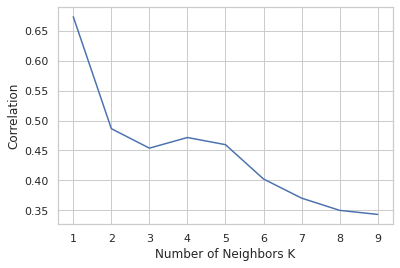

In [27]:
import seaborn as sns

#sns line plot
sns.set(style="whitegrid")
#set x label
plt.xlabel('Number of Neighbors K')
#set y label
plt.ylabel('Correlation')
sns.lineplot(x=k_list, y=corr_list)

In [29]:
import time

n_max = 5000
n_min = 1000
n_step = 500

protected_classes = ['Sex','Race']
marginal_features = ['Tutored','ParentsCheckHomework','FathersWishes']

computation_time_list_naive = []
computation_time_list_rs = []
computation_time_list_rg = []
n_list = []
for n in range(n_min, n_max, n_step):
    print("n", n)
    n_list.append(n)
    #naive 
    print("Naive")
    start = time.time()
    new = NaiveSwapAuditor(data=toy_dataframe[:n], predictor=rf, id_column="StudentId",protected_classes=protected_classes, target_col='GradesUndergrad')
    new.calculate_all_stability(marginal_features=marginal_features)
    end = time.time()
    computation_time_list_naive.append(end-start)

    #randomized sampling
    print("Randomized Sampling")
    start = time.time()
    randomized = RandomizedSamplingSwapAuditor(data=toy_dataframe[:n], predictor=rf, id_column="StudentId",protected_classes=protected_classes, target_col='GradesUndergrad')
    randomized.calculate_all_stability(marginal_features=marginal_features, delta=0.1, epsilon=0.5)
    end = time.time()
    computation_time_list_rs.append(end-start)

    #randomized_group
    print("Randomized Group")
    start = time.time()
    randomized_group = RandomizedGroupSwapAuditor(data=toy_dataframe[:n], predictor=rf, id_column="StudentId",protected_classes=protected_classes, target_col='GradesUndergrad')
    randomized_group.calculate_all_stability(marginal_features=marginal_features, delta=0.1, epsilon=0.5, t=1)
    end = time.time()
    computation_time_list_rg.append(end-start)

n 1000
Naive
Randomized Sampling
Iterations: 20
Randomized Group
Iterations: 1
n 1500
Naive
Randomized Sampling
Iterations: 21
Randomized Group
Iterations: 1
n 2000
Naive
Randomized Sampling
Iterations: 22
Randomized Group
Iterations: 1
n 2500
Naive
Randomized Sampling
Iterations: 22
Randomized Group
Iterations: 1
n 3000
Naive
Randomized Sampling
Iterations: 23
Randomized Group
Iterations: 1
n 3500
Naive
Randomized Sampling
Iterations: 23
Randomized Group
Iterations: 1
n 4000
Naive
Randomized Sampling
Iterations: 23
Randomized Group
Iterations: 1
n 4500
Naive
Randomized Sampling
Iterations: 23
Randomized Group
Iterations: 1


<AxesSubplot:xlabel='Number of samples', ylabel='Computation time (s)'>

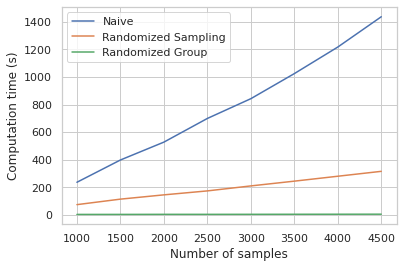

In [31]:
import seaborn as sns

#sns line plot
sns.set(style="whitegrid")
#set x label
plt.xlabel('Number of samples')
#set y label
plt.ylabel('Computation time (s)')
sns.lineplot(x=n_list, y=computation_time_list_naive, label="Naive")
sns.lineplot(x=n_list, y=computation_time_list_rs, label="Randomized Sampling")
sns.lineplot(x=n_list, y=computation_time_list_rg, label="Randomized Group")